In [ ]:
import pandas as pd
samples = [
    'Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h'
]

in_dir = '/data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2'
out_dir = '/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2'
for sample in samples:
    df = pd.read_csv("%s/%s.txt" % (in_dir, sample), sep='\t')
    df_closest= pd.read_csv("%s/counts.rlog.closest_gene.txt" % (in_dir), index_col=0, sep='\t',
                            names=['peak', 'genes', 'distance'])
    df.join(df_closest, how='outer')\
        .to_csv("%s/%s.with_closest_gene.txt" % (out_dir, sample), sep='\t')


In [2]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Keith/Treg/data/integration/plots
source /data/reddylab/software/miniconda2/bin/activate alex_dev
module load gcc
for fdr in $(echo 0.05);
do 
python /data/reddylab/Revathy/scripts/combined_scatter_plot_of_deseq2_results_v1.py \
    -1 /data/reddylab/Revathy/collabs/Keith/Treg/data/atac_seq/deseq/Treg.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt  \
    -2 /data/reddylab/Revathy/collabs/Keith/Treg/data/rna_seq/deseq/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt \
    --suffixes "_atacseq" "_rnaseq" \
    --padj-cols "padj_atacseq" "padj_rnaseq" \
    --log2fc-cols "log2FoldChange_atacseq" "log2FoldChange_rnaseq" \
    --legend-group-labels "DA" "DEG" \
    --axes-labels "ATAC-seq log2fc" "RNA-seq log2fc" \
    --how "inner" \
    --genes-to-highlight "Rorc" "Maf" "Il17a"\
    --gene-name-col "GeneName" \
    --output-format png pdf \
    --fdr-thres ${fdr} \
    --input-file1-join-col "genes" \
    --input-file2-join-col "GeneName" \
    --colors 'grey' '#008695' '#E68310' '#E73F74'  \
    --remove-pseudogenes \
    --fig_size_x 8 \
    --fig_size_y 6 \
    -o /data/reddylab/Revathy/collabs/Keith/Treg/data/integration/plots/Treg_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr${fdr}  
    
done

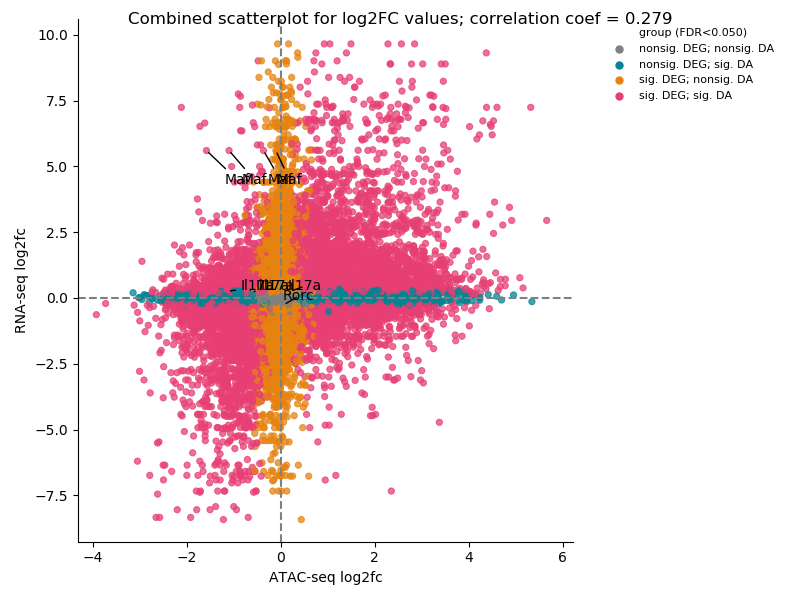

In [8]:
from IPython.display import display,Image
display(Image('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/plots/Treg_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05.png'))
    

In [9]:
!head /data/reddylab/Revathy/collabs/Keith/Treg/data/integration/plots/Treg_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05.txt

Unnamed: 0_atacseq	baseMean_atacseq	log2FoldChange_atacseq	lfcSE_atacseq	pvalue_atacseq	padj_atacseq	genes	distance	Unnamed: 0_rnaseq	baseMean_rnaseq	log2FoldChange_rnaseq	lfcSE_rnaseq	pvalue_rnaseq	padj_rnaseq	GeneName	GeneType	group (FDR<0.050)
chr10_100542826_100543868	434.89809418634	0.209585265394276	0.138429546390332	0.0194186734141315	0.0500124932175985	Cep290	0	ENSMUSG00000019971.10	1037.45227980716	-0.0428356724855795	0.108966536216883	0.669503516983325	0.727835751459106	Cep290	protein_coding	nonsig. DEG; nonsig. DA
chr10_100588522_100589525	256.56889858324	0.0680858511503445	0.117859706707722	0.328904149935415	0.485238115407997	4930430F08Rik	0	ENSMUSG00000046567.10	745.064002113144	0.0557759672452727	0.1206524718775	0.609074461081313	0.673178402360945	4930430F08Rik	protein_coding	nonsig. DEG; nonsig. DA
chr10_105262467_105263985	53.408134192713	1.84180997717423	0.356844222260445	2.1604817795102798e-08	1.7723391026684198e-07	Tmtc2	0	ENSMUSG00000036019.8	474.26672606110606	0.55

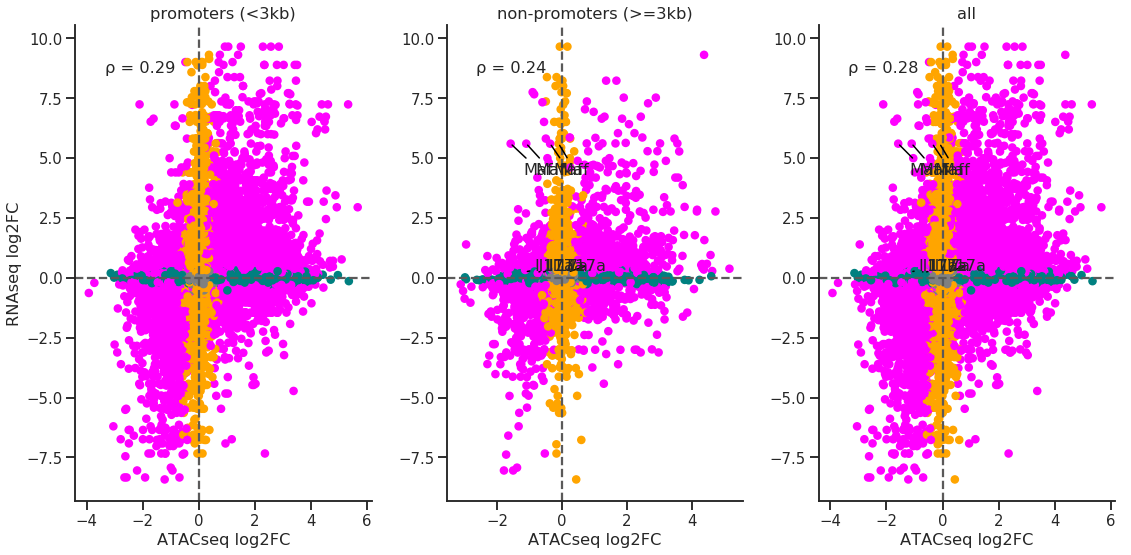

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 
%matplotlib inline


def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(.1, .9), xycoords=ax.transAxes)


merged = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Treg/data/integration/plots/Treg_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05.txt', sep='\t')
merged['Annotation'] = ['Promoter' if (x < 3000) else 'Non-promoter' for x in merged['distance']] 
# merged_promoter = merged[merged['Annotation'] == 'Promoter']
# merged_nonpromoter = merged[merged['Annotation'] == 'Non-promoter']
colors = {'sig. DEG; sig. DA': 'magenta', 'sig. DEG; nonsig. DA': 'orange', 'nonsig. DEG; sig. DA': 'teal', 'nonsig. DEG; nonsig. DA': 'grey'}


sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.9)
fig, ax = plt.subplots(1, 3, figsize=(16,8))

ax1 = ax.flatten()[0]
points = ax1.scatter(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'],
    c=merged.loc[np.abs(merged.distance)<3000, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=50)
corrfunc(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'],
    ax=ax1, method='spearman'
)

ax2 = ax.flatten()[1]
points = ax2.scatter(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'],
    c=merged.loc[np.abs(merged.distance)>=3000, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=50)
corrfunc(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'],
    ax=ax2, method='spearman'
)

ax3 = ax.flatten()[2]
points = ax3.scatter(
    merged.loc[:, 'log2FoldChange_atacseq'],
    merged.loc[:, 'log2FoldChange_rnaseq'],
    c=merged.loc[:, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=50)
corrfunc(
    merged.loc[:, 'log2FoldChange_atacseq'],
    merged.loc[:, 'log2FoldChange_rnaseq'],
    ax=ax3, method='spearman'
)

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ATACseq log2FC')
ax1.set_ylabel('RNAseq log2FC')
ax1.set_title('promoters (<3kb)')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ATACseq log2FC')
ax2.set_title('non-promoters (>=3kb)')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.set_xlabel('ATACseq log2FC')
ax3.set_title('all')
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')

sig_genes = ['Il17a', 'Maf']

### can take unique of the genes with the highest values of log2FC for annotating
for x, y, t in zip(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'], 
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'], 
    merged.loc[np.abs(merged.distance)<3000, 'genes']):
    if t not in sig_genes: continue
    ax1.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))
    
for x, y, t in zip(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'], 
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'], 
    merged.loc[np.abs(merged.distance)>=3000, 'genes']):
    if t not in sig_genes: continue
    ax2.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))

for x, y, t in zip(
    merged.loc[:, 'log2FoldChange_atacseq'], 
    merged.loc[:, 'log2FoldChange_rnaseq'], 
    merged.loc[:, 'genes']):
    if t not in sig_genes: continue
    ax3.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))

# plt.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=10, labels=labels)
# plt.ylabel('RNAseq logFC')
# plt.xlabel('ATACseq logFC')

sns.despine()
plt.tight_layout()
#plt.savefig('/data/reddylab/Revathy/dev/Keith/data/integrative/plots/coordinate_plot_ATAC_RNA_Pdpn.pdf')

plt.show()